In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rdm
import scipy.stats as sps

# Multilevel Monte Carlo Simulation

## simulation functions

In [2]:
def simulation_Y(l:int,m:int,ns:list,model):
    '''
    Simulation function for a certain epsilon and a certain model
    parameters:
        l: max level
        m: parameter to define timesteps
        ns: how many simulation paths need to be simulated(based on epsilon and V_l)
        model: (class) dynamic and payoff functions
    return: 
        mean,var : empirical esimation based on ^P = E[P_0] + \sum E[P_l-P_(l-1)]
    '''
    mean = np.zeros(l+1)
    var = np.zeros(l+1)
    _mean = np.zeros(l+1)
    _var = np.zeros(l+1)
    #E(P_0)
    S = model.dynamic.P0(ns[0],model.T,model.path)
    mean[0] = np.mean(model.payoff(S))
    var[0] = np.var(model.payoff(S))
    _mean[0] = np.mean(model.payoff(S))
    _var[0] = np.var(model.payoff(S))
    for i in range(1,l+1):
        #Sl,Sl-1
        S1,S2= model.dynamic.multi_level(model,i,m,ns[i])
        mean[i] = np.mean(model.payoff(S1)-model.payoff(S2))
        var[i] = np.var(model.payoff(S1)-model.payoff(S2))
        _mean[i] = np.mean(model.payoff(S1))
        _var[i] = np.var(model.payoff(S1))
    return mean,var,_mean,_var

In [3]:
def Nl(eps:float,m:int,L:float,T:int,Vl:list):
    '''Calculate N_l based on V_l(variance) and h_l(timestep) by equation (12)'''
    hls = [T/m**i for i in range(L+1)]
    vhs = sum([np.sqrt(Vl[i]/hls[i]) for i in range(L+1)])
    nls = [int(np.ceil(2*eps**(-2)*np.sqrt(Vl[i]*hls[i])*vhs)) for i in range(L+1)]
    return np.array(nls)

## model  (dynamic + payoff)

### dynamic -- Geometric

In [4]:
class geometric(object):
    '''Geomatric Brownian motion'''
    def __init__(self,r=0.05,sigma=0.2,S0=1):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
    #related Euler scheme with given dW
    def euler(self,dt,dW,path):
        h,n = dW.shape
        S0 = self.S0
        if path:
            S = np.zeros((h+1,n))
            S[0] = S0
            for i in range(h):
                S[i+1] = S[i]*(1+dt*self.r+dW[i]*self.sigma)
        else:
            S = S0
            for i in range(h):
                S *= 1+dt*self.r+dW[i]*self.sigma
        return S
    #multilevel method for geometric dynamic
    def multi_level(self,model,l,m,n):
        h = m**l
        dt = model.T/h
        dW = rdm.normal(size=(h,n),scale=np.sqrt(dt))
        S1 = self.euler(dt,dW,model.path)
        dW = np.array([sum(dW[i*m:(i+1)*m]) for i in range(h//m)])
        S2 = self.euler(dt*m,dW,model.path)
        return S1,S2
    #calculate P_0 seperately
    def P0(self,n,dt,path,l=1):
        dW = rdm.normal(size=(l,n),scale=np.sqrt(dt))
        return self.euler(dt,dW,path)

### dynamic -- Heston

In [5]:
class Heston(object):
    '''Heston Stochastic Volatility Model'''
    def __init__(self,S0=1,V0=0.04,r=0.05,sigma=0.2,lbd=5,xi=0.25,rho=-0.5):
        self.S0=S0
        self.V0=V0
        self.r=r
        self.sigma=sigma
        self.lbd=lbd
        self.xi=xi
        self.rho=rho
    #related Euler scheme with given dW
    def euler(self,dt,dW1,dW2,path):
        h,n = dW1.shape
        if path:
            S = np.zeros((h+1,n))
            V = np.zeros((h+1,n))
            S[0] = self.S0
            V[0] = self.V0
            for i in range(h):
                V_p = np.sqrt(np.maximum(V[i],0))
                S[i+1] = S[i]*(1+self.r*dt+V_p*dW1[i])
                V[i+1] = self.sigma**2 + np.exp(-self.lbd*dt)*((V[i]-self.sigma**2)+self.xi*V_p*dW2[i])
        else:
            S,V = self.S0,self.V0
            for i in range(h):
                V_p = np.sqrt(np.maximum(V,0))
                S *= 1+self.r*dt+V_p*dW1[i]
                V = self.sigma**2 + np.exp(-self.lbd*dt)*((V-self.sigma**2)+self.xi*V_p*dW2[i])
        return S
    #multilevel method for geometric dynamic
    def multi_level(self,model,l,m,n):
        h = m**l
        dt = model.T/h
        _dW1 = rdm.normal(size=(h,n),scale=np.sqrt(dt))
        _dW2 = rdm.normal(size=(h,n),scale=np.sqrt(dt))
        theta = np.arcsin(self.rho)/2
        dW1 = np.cos(theta)*_dW1+np.sin(theta)*_dW2
        dW2 = np.sin(theta)*_dW1+np.cos(theta)*_dW2
        S1 = self.euler(dt,dW1,dW2,model.path)
        dW1 = np.array([sum(dW1[i*m:(i+1)*m]) for i in range(h//m)])
        dW2 = np.array([sum(dW2[i*m:(i+1)*m]) for i in range(h//m)])
        S2 = self.euler(dt*m,dW1,dW2,model.path)
        return S1,S2
    #calculate P_0 seperately
    def P0(self,n,dt,path,l=1):
        _dW1 = rdm.normal(size=(l,n),scale=np.sqrt(dt))
        _dW2 = rdm.normal(size=(l,n),scale=np.sqrt(dt))
        theta = np.arcsin(self.rho)/2
        dW1 = np.cos(theta)*_dW1+np.sin(theta)*_dW2
        dW2 = np.sin(theta)*_dW1+np.cos(theta)*_dW2
        return self.euler(dt,dW1,dW2,path)

## Payoff
### payoff -- European options

In [6]:
class European_options(object):
    def __init__(self,K=1,T=1,call=True,dynamic=geometric(),path=False):
        self.K = K
        self.T = T
        self.dynamic = dynamic
        self.path = path
        if call:
            self.payoff = self.payoff_c
        else:
            self.payoff = self.payoff_p
    
    def payoff_c(self,ST):
        return np.exp(-self.dynamic.r)*np.maximum(0,ST-self.K)
    
    def payoff_p(self,ST):
        return np.exp(-self.dynamic.r)*np.maximum(0,-ST+self.K)
    
    def BS(self):
        r,sigma,x,K,T=self.dynamic.r,self.dynamic.sigma,1,self.K,self.T
        d=(np.log(x/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
        p=x*sps.norm.cdf(d)-K*np.exp(-r*T)*sps.norm.cdf(d-sigma*np.sqrt(T))
        return p

### payoff -- Asian options

In [7]:
class Asian_options(object):
    def __init__(self,K=1,T=1,call=True,dynamic=geometric(),path=True):
        self.K = K
        self.T = T
        self.dynamic = dynamic
        self.path = path
        if call:
            self.payoff = self.payoff_c
        else:
            self.payoff = self.payoff_p
    
    def payoff_c(self,ST):
        dt = 1/(ST.shape[0]-1)
        Sbar = np.sum(dt*(ST[:-1]+ST[1:])/2,axis=0)
        return np.exp(-self.dynamic.r)*np.maximum(0,Sbar-self.K)
    
    def payoff_p(self,ST):
        dt = 1/(ST.shape[0]-1)
        Sbar = np.sum(dt*(ST[:-1]+ST[1:])/2,axis=0)
        return np.exp(-self.dynamic.r)*np.maximum(0,-Sbar+self.K)

### payoff -- Lookback Options

In [23]:
class Lookback_options(object):
    def __init__(self,T=1,call=True,dynamic=geometric(),path=True):
        self.T = T
        self.dynamic = dynamic
        self.path = path
        if call:
            self.payoff = self.payoff_c
        else:
            self.payoff = self.payoff_p
    
    def payoff_c(self,ST):
        h = self.T/ST.shape[0]
        min_tmp = np.min(ST,axis=0)
        min_tmp *= (1-0.5826*self.dynamic.sigma*np.sqrt(h))
        return np.exp(-self.dynamic.r)*np.maximum(0,ST[-1]-min_tmp)
    
    def payoff_p(self,ST):
        return np.exp(-self.dynamic.r)*np.maximum(0,-ST[-1]+np.min(ST,axis=0))

### payoff - Digital Options

In [9]:
class Digital_options(object):
    def __init__(self,K=1,T=1,call=True,dynamic=geometric(),path=False):
        self.T = T
        self.K = K
        self.dynamic = dynamic
        self.path = path
        if call:
            self.payoff = self.payoff_c
        else:
            self.payoff = self.payoff_p
    
    def payoff_c(self,ST):
        return np.exp(-self.dynamic.r)*(0<ST-self.K)
    
    def payoff_p(self,ST):
        return np.exp(-self.dynamic.r)*(0<-ST+self.K)

## Plot function

In [10]:
def plot(mean_vars,mc_means,mc_vars,title='',**argv):
    '''integrate plot function'''
    plt.figure(figsize=(14,4))
    plt1 = plt.subplot(1,2,1)
    colors,i = ['firebrick','royalblue','orange','seagreen'],0
    x = range(1,len(mc_means))
    for mean1,var1,epsilon in mean_vars:
        color = colors[i]
        i+=1
        plt1.plot(x,(np.log(abs(mean1))/np.log(4))[1:],c=color,marker='.',label='$P_l-P_{l-1} \epsilon$='+epsilon) 
    plt1.plot(np.log(mc_means)/np.log(4),c='black',marker='.',label='$P_l$') 
    if 'bs' in argv:
        plt1.axhline(argv['bs'],c='seagreen',label='B-S exact value',linestyle=':',alpha=0.85)
    plt.legend(loc='best')
    plt.grid()
    plt.title('mean of '+title)
    plt.xlabel('l')
    plt.ylabel('$\log_m (\mathbb{E}(Y))$')
#     plt.show()
    plt2 = plt.subplot(1,2,2)
    i=0
    for mean1,var1,epsilon in mean_vars:
        color = colors[i]
        i+=1
        plt2.plot(x,(np.log(var1)/np.log(4))[1:],c=color,marker='.',label='$P_l-P_{l-1} \epsilon$='+epsilon)
#     plt2.axhline(var2,c='black',label='Euler Scheme $\epsilon$='+epsilon)
    plt2.plot(np.log(mc_vars)/np.log(4),c='black',marker='.',label='$P_l$') 
    plt.title('Var of '+title)
    plt.legend(loc='best')
    plt.xlabel('l')
    plt.ylabel('\log_m (var(Y))')
    plt.grid()
    plt.show()
def plot_nl(eps,var,title,l=6):
    '''n_l plot function'''
    plt.figure(figsize=(6,4))
    for i in eps:
        nl = Nl(i,4,l,1,var)
        plt.plot(np.log(nl)/np.log(10),marker='o',label='$\epsilon=$'+str(i))
    plt.legend(loc='best')
    plt.grid()
    plt.title('$N_l$ with different $\epsilon$'+title)
    plt.xlabel('l')
    plt.ylabel('$N_l:\log_{10}$')
    plt.show()
def plot_complexity(cpl1,cpl2,eps,title=''):
    '''complexity plot function--compare with standard monte carlo'''
    plt.figure(figsize=(6,4))
    plt.title('complexity of '+title)
    plt.plot(eps,np.log(cpl1)/np.log(10),marker='o',label='multilevel',c='firebrick')
    plt.plot(eps,np.log(cpl2)/np.log(10),marker='^',label='std monte carlo',c='royalblue')
    plt.legend(loc='best')
    plt.xlabel('$\epsilon$')
    plt.ylabel('$\epsilon^2$Complexity')
    plt.xticks(labels=eps,ticks=eps)
    plt.yticks(labels=['$10^{-2}$','$10^{-1}$','$10^0$','$10^1$','$10^2$'],ticks=[-2,-1,0,1,2])
    plt.grid()
    plt.show()

## Test -- (in paper)

In [11]:
#dynamics
geo = geometric(r=0.05,S0=1,sigma=0.2)
hes = Heston()

In [12]:
eps = np.array([0.001,0.0005,0.0002,0.0001])
def multilevel(model,title,l=6):
    '''integrate multilevel method depends on model'''
    np.random.seed(1)
    #estimate Vl (with n = 10^4) and compare the variance
    mean,var,_m,_v = simulation_Y(l=l,m=4,ns=[10**4 for i in range(l+1)],model=model)
    #use Vl to calculate optimal Nl
    plot_nl(eps,var,title,l=l)
    #calculate the variance
    information = []
    complexity1 = []
    complexity2 = []
    mc_var = 0
    for epsilon in eps:
        nl = Nl(epsilon,4,l,1,var)
        mean,var,_mean,_var = simulation_Y(l=l,m=4,ns=nl,model=model)
#         var = var.cumsum()
        information.append([mean,var,str(epsilon)])
        cpl = nl[0] + sum([nl[i]*(4**i+4**(i-1)) for i in range(1,l+1)])
        complexity1.append(cpl*epsilon**2)
        for _l in range(3):
            tmp_S = model.dynamic.P0(10**3,1/4**_l,model.path,4**_l)
            tmp_var = np.var(model.payoff(tmp_S))
            mc_var += 2*tmp_var*4**_l
        complexity2.append(mc_var)
    
    plot(information,_mean,_var,title=title)
    plot_complexity(np.array(complexity1),np.array(complexity2),eps,title)
    print(title+' mean',sum(mean))

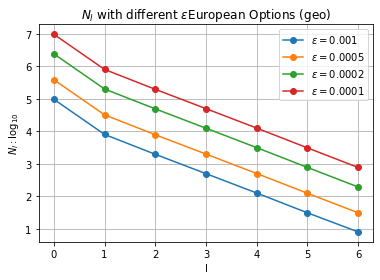

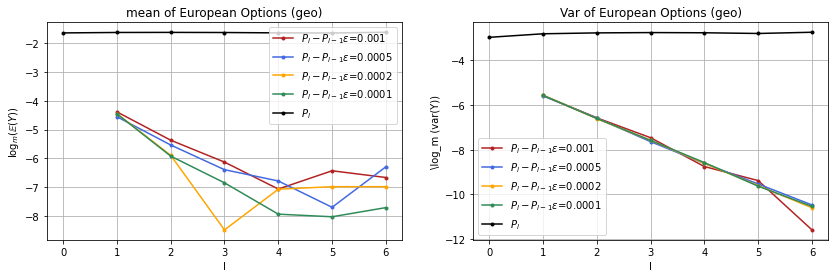

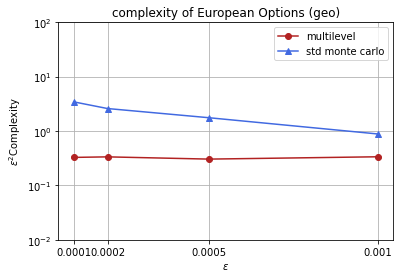

European Options (geo) mean 0.10443082336382276


In [21]:
#Euporean options with geometric dynamic
eo = European_options(dynamic=geo)
multilevel(eo,'European Options (geo)')

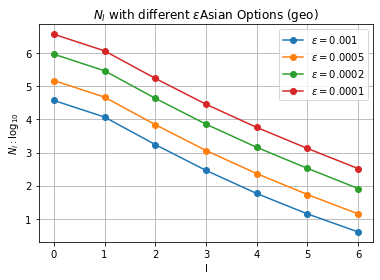

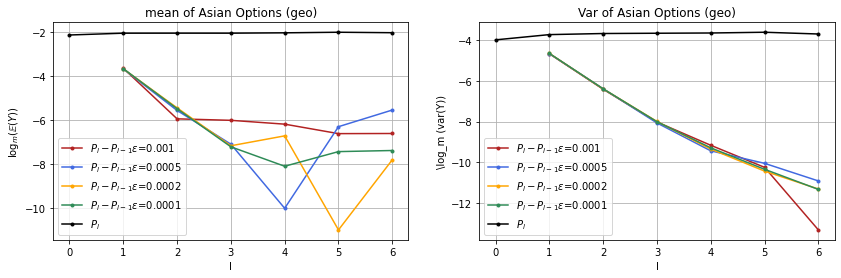

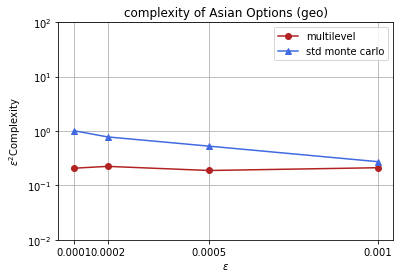

Asian Options (geo) mean 0.05774221365847151


In [22]:
#Asian options with geometric dynamic
ao = Asian_options(dynamic=geo)
multilevel(ao,'Asian Options (geo)')

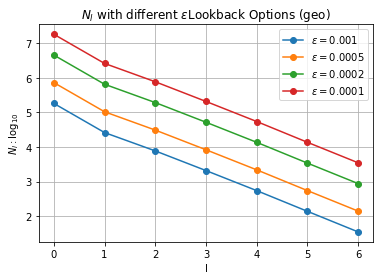

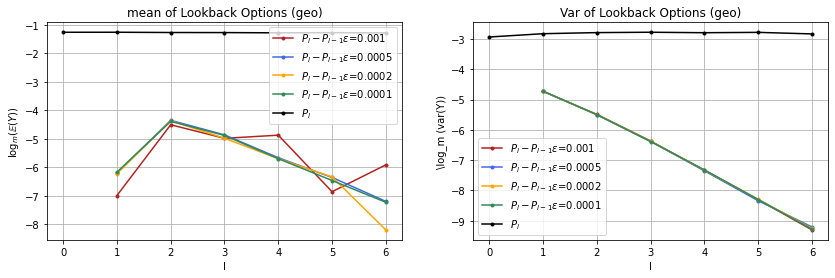

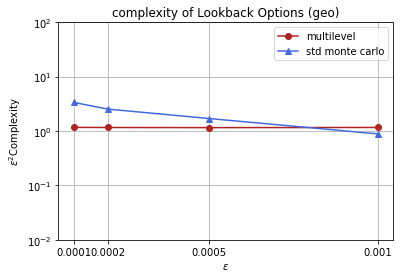

Lookback Options (geo) mean 0.1721337227030276


In [24]:
#Lookback options with geometric dynamic
lo = Lookback_options(dynamic=geo)
multilevel(lo,'Lookback Options (geo)')

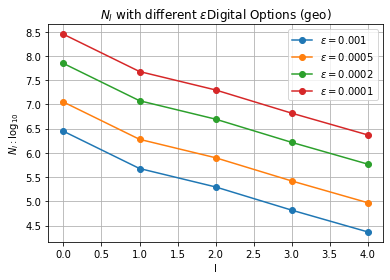

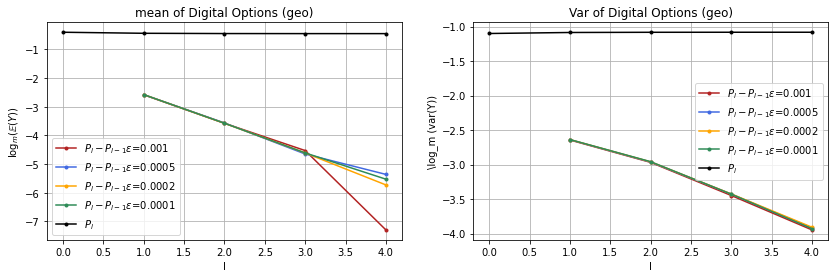

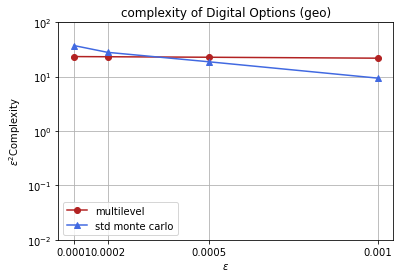

Digital Options (geo) mean 0.5323753087574954


In [24]:
#Digital options with geometric dynamic
do = Digital_options(dynamic=geo)
multilevel(do,'Digital Options (geo)',l=4)

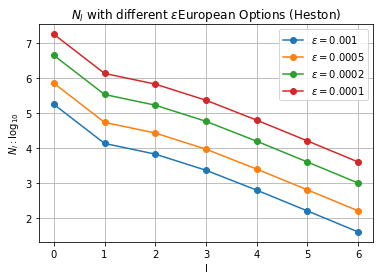

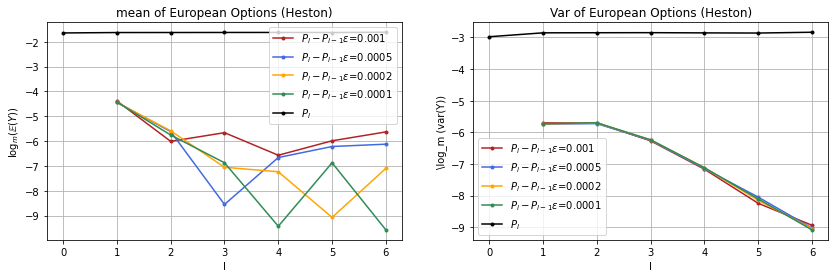

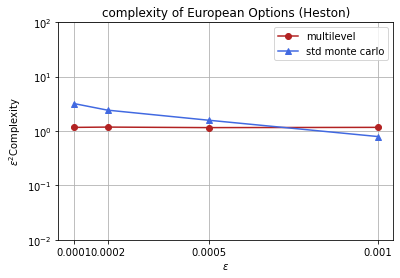

European Options (Heston) mean 0.10465004990315592


In [25]:
#European options with Heston dynamic
eoh = European_options(dynamic=hes)
multilevel(eoh,'European Options (Heston)')